In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer


if False:  # Fetch from OpenML
    from sklearn.datasets import fetch_openml
    
    df = fetch_openml(data_id=45106, parser="pandas").frame
else:     # Fetch from repo
    df = pl.read_parquet("df.parquet")
df

year,town,driver_age,car_weight,car_power,car_age,claim_nb
f64,f64,f64,f64,f64,f64,i32
2018.0,1.0,51.0,1760.0,173.0,3.0,0
2019.0,1.0,41.0,1760.0,248.0,2.0,0
2018.0,1.0,25.0,1240.0,111.0,2.0,0
2019.0,0.0,40.0,1010.0,83.0,9.0,0
2018.0,0.0,43.0,2180.0,169.0,5.0,0
…,…,…,…,…,…,…
2019.0,1.0,45.0,1090.0,62.0,2.0,0
2019.0,1.0,45.0,1180.0,93.0,4.0,0
2018.0,1.0,31.0,1060.0,57.0,1.0,0


In [2]:
vars_discretize = ["driver_age", "car_weight", "car_power", "car_age"]
covs = vars_discretize
kbins_ordinal = KBinsDiscretizer(n_bins=5, encode="ordinal").set_output(transform="polars")
ordinal_data = kbins_ordinal.fit_transform(df[vars_discretize]).with_columns(
    df["claim_nb"],
    df["year"]
)
ordinal_data

driver_age,car_weight,car_power,car_age,claim_nb,year
f64,f64,f64,f64,i32,f64
3.0,4.0,4.0,2.0,0,2018.0
2.0,4.0,4.0,2.0,0,2019.0
0.0,2.0,2.0,2.0,0,2018.0
1.0,0.0,1.0,4.0,0,2019.0
2.0,4.0,4.0,3.0,0,2018.0
…,…,…,…,…,…
2.0,1.0,0.0,2.0,0,2019.0
2.0,2.0,1.0,3.0,0,2019.0
0.0,1.0,0.0,1.0,0,2018.0


In [3]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform="polars")
X_train = ohe.fit_transform(ordinal_data.select(
    pl.all().exclude("claim_nb", "year")
))

In [4]:
from sklearn.linear_model import PoissonRegressor
glm = PoissonRegressor(alpha=1e-3)
glm.fit(X_train, df["claim_nb"])

PoissonRegressor(alpha=0.001)

In [5]:
years = np.arange(2010, 2020)
np.random.seed(500)
sample_years = np.random.choice(years, size=df.height)
df = df.with_columns(
    pl.lit(sample_years).alias("year"),
    pl.lit(glm.predict(X_train)).alias("y_hat")
)
ordinal_data = ordinal_data.with_columns(
    pl.lit(sample_years).alias("year"),
    pl.lit(glm.predict(X_train)).alias("y_hat")
).with_columns(
    pl.all().exclude("year", "claim_nb", "y_hat").cast(str),
)

In [6]:
factors_df = pl.DataFrame(
    {
        "coef_name": X_train.columns,
        "coef_value": np.exp(glm.coef_)
    }
)
factors_df = factors_df.select(
    pl.col("coef_name").str.split("_").map_elements(lambda x: x[:-1]).list.join("_").alias("variable"),
    pl.col("coef_name").str.split("_").list.last().alias("level"),
    pl.col("coef_value")
)
mu = np.exp(glm.intercept_)
factors_df.head()

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


variable,level,coef_value
str,str,f64
"""driver_age""","""0.0""",1.270512
"""driver_age""","""1.0""",0.955437
"""driver_age""","""2.0""",0.941488
"""driver_age""","""3.0""",0.880731
"""driver_age""","""4.0""",0.988261


In [7]:
factors_df.schema

Schema([('variable', String), ('level', String), ('coef_value', Float64)])

In [8]:
def get_pivot_df(year1, year2, factors_df, data, covs, mu):
    dist_1 = data.filter(
        pl.col("year") == year1
    )
    dist_2 = data.filter(
        pl.col("year") == year2
    )
    distrs = pl.DataFrame(
        schema={
            "year": pl.Int32,
            "variable": str,
            "level": str,
            "p_x": pl.Float64,
        }
    )
    for cov in covs:
        _ = dist_1.group_by(
            cov
        ).agg(
            pl.col("year").count().alias("n_obs")
        ).with_columns(
            (pl.col("n_obs") / pl.col("n_obs").sum()).alias("p_x")
        ).select(
        pl.lit(year1).alias("year"),
        pl.lit(cov).alias("variable"),
        pl.col(cov).cast(str).alias("level"),
        pl.col("p_x")
        )
        distrs = pl.concat([distrs, _])
    for cov in covs:
        _ = dist_2.group_by(
            cov
        ).agg(
            pl.col("year").count().alias("n_obs")
        ).with_columns(
            (pl.col("n_obs") / pl.col("n_obs").sum()).alias("p_x")
        ).select(
        pl.lit(year2).alias("year"),
        pl.lit(cov).alias("variable"),
        pl.col(cov).cast(str).alias("level"),
        pl.col("p_x")
        )
        distrs = pl.concat([distrs, _])
    pivot_df = distrs.pivot(
    index=["variable", "level"],
    on="year"
    ).fill_null(0).with_columns(
        (pl.col(str(year2)) - pl.col(str(year1))).alias("delta_px")
    ).join(
        factors_df, on=["variable", "level"]
    ).with_columns(
        (pl.col("coef_value") * pl.col("delta_px")).alias("contribution")
    )
    return pivot_df, mu * pivot_df["contribution"].sum()

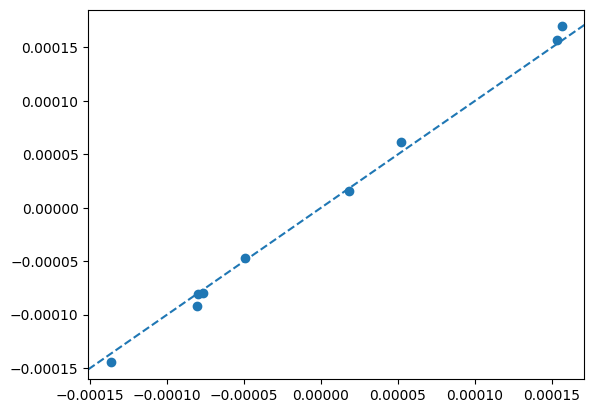

In [9]:
res = []
for year in df["year"].unique().sort()[:-1]:
    res.append(get_pivot_df(year, year + 1, factors_df, ordinal_data, covs, mu))

obs_deltas = ordinal_data.group_by(
    "year"
).agg(
    pl.col("y_hat").mean()
).sort("year").select(
    pl.col("y_hat").diff().alias("diff")
).drop_nulls().to_numpy()
expected_deltas = [el[1] for el in res]
plt.axline((0, 0), slope=1., linestyle="--")
plt.scatter(expected_deltas, obs_deltas)

In [10]:
import plotly.express as px

In [11]:
res[0][0]

variable,level,2010,2011,delta_px,coef_value,contribution
str,str,f64,f64,f64,f64,f64
"""driver_age""","""0.0""",0.193186,0.187329,-0.005857,1.270512,-0.007441
"""driver_age""","""1.0""",0.196137,0.196147,0.00001,0.955437,0.00001
"""driver_age""","""2.0""",0.198598,0.198178,-0.00042,0.941488,-0.000395
"""driver_age""","""3.0""",0.20746,0.2096,0.00214,0.880731,0.001885
"""driver_age""","""4.0""",0.204619,0.208746,0.004126,0.988261,0.004078
…,…,…,…,…,…,…
"""car_age""","""0.0""",0.095558,0.094645,-0.000913,1.069594,-0.000976
"""car_age""","""1.0""",0.170269,0.170156,-0.000114,1.055328,-0.00012
"""car_age""","""2.0""",0.265327,0.263202,-0.002125,1.013719,-0.002154


In [12]:
fig = px.bar(res[0][0].sort("contribution"), 
             x="contribution", y="variable", 
             orientation='h', color="coef_value",
             hover_data={
                 "delta_px": ':.2%',
                 "level": True
             }
             )
fig.add_vline(x=0, line_width=10, line_color="white")
fig.show()